### Analyse the air quality in India using Earth Engine and satellite data

In [2]:
#importing needed libraries
from os import path as op
import pickle
import json
import fiona
import geemap
import ipyleaflet
import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterstats.io import bounds_window
import rasterstats
import folium


In [8]:
import ee #earth engine

In [9]:
ee.Authenticate()

Enter verification code:  4/1AX4XfWh86dxF9GWi1mAiwPoXlSs-bLw2fBKekEa1HyvD2SclcsXdIHg42vc



Successfully saved authorization token.


In [11]:
ee.Initialize()

In [296]:
#load geojson satellite data for south-east asia
polygons = []
with open('/home/jovyan/Analysis/Impacts-of-COVID-19/India_shape/south_asia.geojson') as igj:
    source = json.load(igj)
    src_geo = [feat["geometry"] for feat in source["features"]]

In [333]:
#check where india is. I used QGIS for this
source["features"][16]['properties'] #can see that india is the 16th country, it will be our area of interest (aoi)

{'featurecla': 'Admin-0 country',
 'NAME_LONG': 'India',
 'cartodb _2': 'Co-sponsor of Yoga Day resolution and not an OIC member state'}

In [311]:
india = source["features"][16]["geometry"]

In [320]:
aoi=ee.Geometry.MultiPolygon(india["coordinates"])# loading area of interest

In [323]:
s2=ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_NO2') #check for NO2 levels, copernicus
collection = s2.select('NO2_column_number_density').filterBounds(aoi) #extract data for our aoi (india)
def display_(start_date,end_date,i):
  cc=collection.filterDate(start_date, end_date).mean()
  clip=cc.clip(aoi)
  clip_mean=clip.reduce(ee.Reducer.mean())
  # Display the NO2 level in India.
  str1='NO2 Concentration before Lockdown from Jan 01 to jan 30' #before lockdown
  str2='NO2 Concentration During Lockdown from June 01 to june 30' #during lockdown
  str3='NO2 Concentration After Lockdown from Dec 01 to Dec 30' #after lockdown
  if i==1:
    print(str1)
  if i==2:
    print(str2)
  if i==3:
    print(str3)
  from IPython.display import Image
  # Create a URL to the styled image for a region around India.
  url = clip_mean.getThumbUrl({'min': 0.00, 'max': 0.00017, 'dimensions': 512, 'region': aoi, 'palette':['black','blue','purple','cyan','green','yellow','red']})
  return url



#### You will need to run these scripts to view these images.

However, you can alternatively see the images in the folder:

"Air-Quality-jpgs" for NO2 levels before, during and after lockdown.

In [358]:
from IPython.display import Image
Image(url=display_('2020-01-01','2020-01-30',1)) #show levels before lockdown

NO2 Concentration before Lockdown from Jan 01 to jan 30


In [360]:
Image(url=display_('2020-06-01','2020-06-30',2)) #show levels during lockdown

NO2 Concentration During Lockdown from June 01 to june 30


In [361]:
Image(url=display_('2020-12-01','2020-12-30',3)) #show levels after lockdown

NO2 Concentration After Lockdown from Dec 01 to Dec 30


#### We will then see the time-series data of these before, during and after lockdown

In [149]:
import pandas as pd

In [150]:
roi=ee.Geometry.Point(77.2308,28.6117).buffer(500) #obtaining for india

In [151]:
def roi_mean(img): #FIND AVERAGE
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi, scale=30).get('NO2_column_number_density')
    return img.set('date', img.date().format()).set('mean',mean)

In [152]:
def monthly_mean_NO2(m): #FIND MEAN FOR MONTHLY DATA
  strt='2020-'+m+'-01'
  end='2020-'+m+'-28'
  collect=ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_NO2').filterDate(strt,end)
  roi_reduced_imgs = collect.map(roi_mean)
  nested_list = roi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)
  df = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])

  return (df['mean'].mean())

In [153]:
no=[]
month=['01','02','03','04','05','06','07','08','09','10','11','12'] #OBSERVE FOR EVERY MONTH OF THE YEAR
for i in range(12):
  no.append(monthly_mean_NO2(month[i]))


In [154]:
y=no
x=month

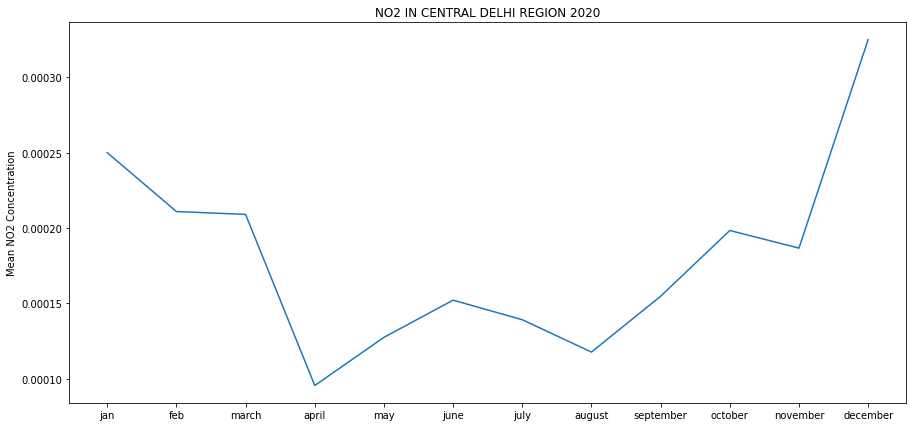

In [155]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,7))
plt.plot(x,y)

x_ticks = x
x_labels = ['jan','feb','march','april','may','june','july','august','september','october','november','december']
plt.xticks(ticks=x_ticks, labels=x_labels)

plt.ylabel("Mean NO2 Concentration")
plt.title('NO2 IN CENTRAL DELHI REGION 2020')

plt.show()

#### Let's repeat these figures for Carbon monoxide levels (CO) instead

In [180]:
def roi_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi, scale=30).get('CO_column_number_density')
    return img.set('date', img.date().format()).set('mean',mean)

In [181]:
def monthly_mean_CO(m):
  strt='2020-'+m+'-01'
  end='2020-'+m+'-28'
  collect=ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_CO').filterDate(strt,end)
  roi_reduced_imgs = collect.map(roi_mean)
  nested_list = roi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)
  df = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])

  return (df['mean'].mean())

In [182]:
co=[]
month=['01','02','03','04','05','06','07','08','09','10','11','12']
for i in range(12):
  co.append(monthly_mean_CO(month[i]))

In [184]:
y=co
x=month

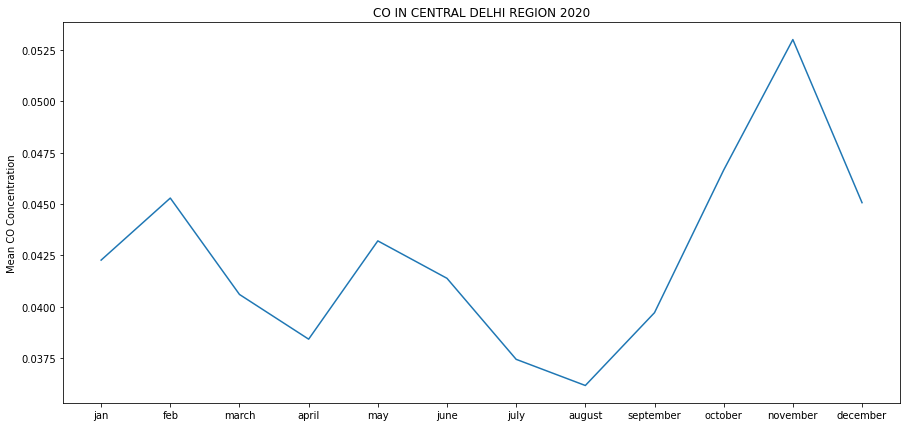

In [388]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,7))
plt.plot(x,y)

x_ticks = x
x_labels = ['jan','feb','march','april','may','june','july','august','september','october','november','december']
plt.xticks(ticks=x_ticks, labels=x_labels)

plt.ylabel("Mean CO Concentration")
plt.title('CO IN CENTRAL DELHI REGION 2020')

plt.show()

In [383]:
s2=ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_CO')
collection = s2.select('CO_column_number_density').filterBounds(aoi)
def display_(start_date,end_date,i):
  cc=collection.filterDate(start_date, end_date).mean()
  clip=cc.clip(aoi)
  clip_mean=clip.reduce(ee.Reducer.mean())
  # Display the NO2 level in India.
  str1='CO Concentration before Lockdown from Jan 01 to jan 30'
  str2='CO Concentration During Lockdown from June 01 to june 30'
  str3='CO Concentration After Lockdown from Dec 01 to Dec 30'
  if i==1:
    print(str1)
  if i==2:
    print(str2)
  if i==3:
    print(str3)
  from IPython.display import Image
  # Create a URL to the styled image for a region around France.
  url = clip_mean.getThumbUrl({'min': 0.00, 'max': 0.05, 'dimensions': 512, 'region': aoi, 'palette':['black','blue','purple','cyan','green','yellow','red']})
  return url



#### You will need to run these scripts to view these images.

However, you can alternatively see the images in the folder:

"Air-Quality-jpgs" for CO levels before, during and after lockdown.

In [384]:
Image(url=display_('2020-01-01','2020-01-30',1))

CO Concentration before Lockdown from Jan 01 to jan 30


In [385]:
Image(url=display_('2020-06-01','2020-06-30',2))

CO Concentration During Lockdown from June 01 to june 30


In [387]:
Image(url=display_('2020-12-01','2020-12-30',3))

CO Concentration After Lockdown from Dec 01 to Dec 30
